In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os

from PIL import Image
from random import randint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,precision_score,roc_curve,auc,recall_score,precision_score,average_precision_score,accuracy_score

from keras.layers import LeakyReLU
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
import os
import skimage
from pathlib import Path
import numpy as np
%matplotlib notebook
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from skimage.transform import resize
from skimage.io import imread
from tensorflow.keras.regularizers import l2
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.8/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['imread', 'randint', 'resize']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
WORK_DIR = '/content/drive/MyDrive/Colab Notebooks/data'

CLASSES = [ 'adenocarcinoma',
            'normal',
          "squamous_cell_carcinoma"]

IMG=224

IMAGE_SIZE = [224, 224]
DIM = (IMG,IMG )

model_acc={}
model_val_acc={}

In [4]:
work_dr = IDG(rescale = 1./255, brightness_range=[0.8, 1.2], zoom_range=[.77, 1.01], horizontal_flip=True)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=(224,224), batch_size=3481, shuffle=True)

Found 3481 images belonging to 3 classes.


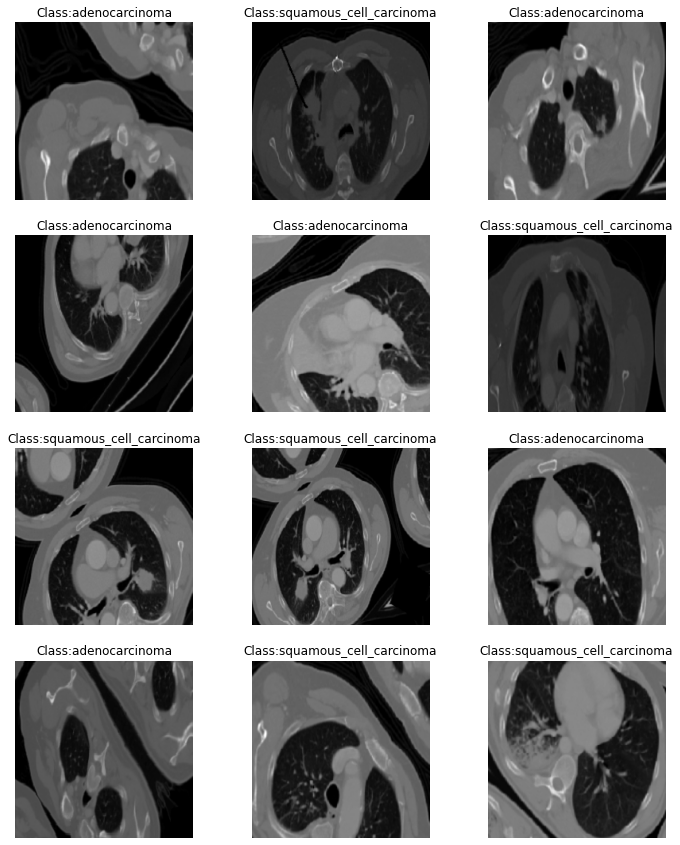

In [5]:
from random import randint
   
# get image lables
labels =dict(zip([0,1,2], CLASSES))
# get a batch of images
train_data, train_labels = train_data_gen.next()
    
# display a grid of 9 images
plt.figure(figsize=(12, 15))
for i in range(12):
  ax = plt.subplot(4, 3, i + 1)
  idx = randint(0,3000)
  plt.imshow(train_data[idx])
  plt.axis("off")
  plt.title("Class:{}".format(labels[np.argmax(train_labels[idx])]))

In [6]:
print(train_data.shape, train_labels.shape)

(3481, 224, 224, 3) (3481, 3)


In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
print(train_data.shape)

(2784, 224, 224, 3)


In [8]:
print(test_data.shape)

(697, 224, 224, 3)


# SVC (support vector classifier)

In [41]:
import cv2
training_data=[]
def create_training_data():
    for category in CLASSES:
        path=os.path.join(WORK_DIR, category)
        class_num=CLASSES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(32,32))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data() 

In [42]:
print(len(training_data))

3481


In [43]:
lenofimage = len(training_data)
X=[]
y=[]

for categories, label in training_data:
    X.append(categories)
    y.append(label)
X= np.array(X).reshape(lenofimage,-1)


In [44]:
X.shape

(3481, 3072)

In [45]:
# flatten the arrary
X = X/255.0
y=np.array(y)

In [ ]:
y

array([0, 0, 0, ..., 2, 2, 2])

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=42)

In [47]:
from sklearn.svm import SVC
model=SVC(probability=True)


In [48]:
# train the model
model.fit(X_train, y_train)

SVC(probability=True)

In [49]:
y_pred_true=model.predict(X_train)
train_score = accuracy_score(y_train,y_pred_true)

In [50]:
y_pred=model.predict(X_test)
test_score = accuracy_score(y_test,y_pred)

In [51]:
model_acc["SVC"]=train_score
model_val_acc["SVC"]=test_score

print("Train accuracy",train_score)
print("Validation accuracy",test_score)

Train accuracy 0.8674568965517241
Validation accuracy 0.7862266857962698


In [52]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.70      0.89      0.79       310
           1       0.98      1.00      0.99       190
           2       0.73      0.41      0.53       197

    accuracy                           0.79       697
   macro avg       0.81      0.77      0.77       697
weighted avg       0.79      0.79      0.77       697



[[277   3  30]
 [  0 190   0]
 [116   0  81]]


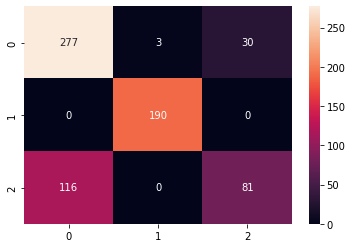

In [53]:
import seaborn as sns
cf = confusion_matrix(y_test,y_pred)

sns.heatmap(cf , annot=True,fmt="1.0f")
print(cf)

# VGG16

In [11]:
from tensorflow.keras.layers import AveragePooling2D
modelvgg = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
modelvgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
#Adding custom Layers 
x = modelvgg.output
x = AveragePooling2D(pool_size=(7, 7))(x)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
predictions = Dense(3,kernel_regularizer=l2(0.01), activation="softmax")(x)

# creating the final model 
model_vgg =  Model(inputs=modelvgg.input, outputs=predictions)

for layer in modelvgg.layers[:25]:
    layer.trainable = False
  
model_vgg.compile(optimizer='adam',
              loss='squared_hinge',
              metrics=["acc"])

In [13]:
EPOCHS = 20
history1 = model_vgg.fit(train_data, train_labels, validation_data=(test_data, test_labels), batch_size=32, epochs=EPOCHS)

Epoch 1/20
87/87 [==============================] - 30s 224ms/step - loss: 1.2258 - acc: 0.5740 - val_loss: 1.1175 - val_acc: 0.6385
Epoch 2/20
87/87 [==============================] - 17s 193ms/step - loss: 1.0980 - acc: 0.6685 - val_loss: 1.0943 - val_acc: 0.6327
Epoch 3/20
87/87 [==============================] - 17s 200ms/step - loss: 1.0694 - acc: 0.6904 - val_loss: 1.0137 - val_acc: 0.7518
Epoch 4/20
87/87 [==============================] - 18s 203ms/step - loss: 1.0351 - acc: 0.7191 - val_loss: 1.0158 - val_acc: 0.7331
Epoch 5/20
87/87 [==============================] - 17s 198ms/step - loss: 1.0081 - acc: 0.7446 - val_loss: 0.9657 - val_acc: 0.7891
Epoch 6/20
87/87 [==============================] - 17s 196ms/step - loss: 0.9987 - acc: 0.7489 - val_loss: 0.9649 - val_acc: 0.7805
Epoch 7/20
87/87 [==============================] - 17s 196ms/step - loss: 0.9627 - acc: 0.7884 - val_loss: 0.9643 - val_acc: 0.7690
Epoch 8/20
87/87 [==============================] - 17s 199ms/step - 

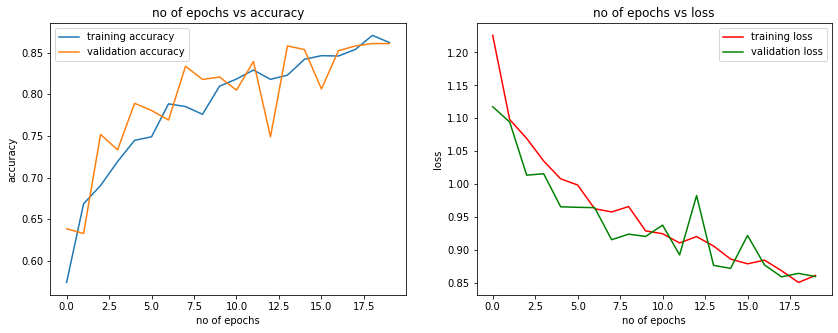

In [14]:
# Accuracy plot
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
acc=history1.history['acc']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)    
plt.plot(epochs_,acc,label='training accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

acc_val=history1.history['val_acc']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation accuracy")
plt.title("no of epochs vs accuracy")
plt.legend()

# loss plot
plt.subplot(1,2,2)
acc=history1.history['loss']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)    
plt.plot(epochs_,acc,label='training loss',color='r')
plt.xlabel('no of epochs')
plt.ylabel('loss')

acc_val=history1.history['val_loss']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation loss",color='g')
plt.title("no of epochs vs loss")
plt.legend()

In [15]:
Train_acc4=history1.history['acc'][-1]
Val_acc4=history1.history['val_acc'][-1]

model_acc["VGG16"]=Train_acc4
model_val_acc["VGG16"]=Val_acc4

print("Train accuracy",Train_acc4)
print("Validation accuracy",Val_acc4)

Train accuracy 0.8620689511299133
Validation accuracy 0.860832154750824


In [16]:
predIdxs1 = model_vgg.predict(test_data, batch_size=32)
predIdxs1 = np.argmax(predIdxs1, axis=1)

22/22 [==============================] - 4s 160ms/step


In [17]:
# show a nicely formatted classification report
print(classification_report(test_labels.argmax(axis=1), predIdxs1))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85       284
           1       0.97      0.99      0.98       209
           2       0.87      0.66      0.75       204

    accuracy                           0.86       697
   macro avg       0.87      0.85      0.86       697
weighted avg       0.87      0.86      0.86       697



[[259   5  20]
 [  2 206   1]
 [ 68   1 135]]


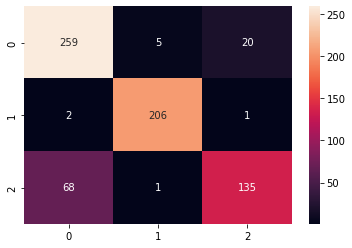

In [18]:
import seaborn as sns
cf1=confusion_matrix(test_labels.argmax(axis=1), predIdxs1)

sns.heatmap(cf1, annot=True,fmt="1.0f")
print(cf1)

# MobilenetV2

In [19]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D

In [20]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
baseModel.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

In [21]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(32, activation="relu")(headModel)
headModel = Dropout(0.4)(headModel)
headModel = Dense(16, activation="relu")(headModel)
headModel = Dropout(0.4)(headModel)
headModel = Dense(3,kernel_regularizer=l2(0.01), activation="softmax")(headModel)

model_2 = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

#Defining other parameters for our CNN model
model_2.compile(optimizer='adam',
              loss='squared_hinge',
              metrics=["acc"])
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [22]:
EPOCHS = 20
history2 = model_2.fit(train_data, train_labels, validation_data=(test_data, test_labels),batch_size=32, epochs=EPOCHS)

Epoch 1/20
87/87 [==============================] - 9s 72ms/step - loss: 1.2567 - acc: 0.5334 - val_loss: 1.0643 - val_acc: 0.6829
Epoch 2/20
87/87 [==============================] - 5s 56ms/step - loss: 1.1324 - acc: 0.6361 - val_loss: 1.0336 - val_acc: 0.7704
Epoch 3/20
87/87 [==============================] - 5s 56ms/step - loss: 1.0721 - acc: 0.6792 - val_loss: 0.9771 - val_acc: 0.7647
Epoch 4/20
87/87 [==============================] - 5s 55ms/step - loss: 1.0114 - acc: 0.7360 - val_loss: 0.9147 - val_acc: 0.8379
Epoch 5/20
87/87 [==============================] - 5s 56ms/step - loss: 0.9573 - acc: 0.7917 - val_loss: 0.8932 - val_acc: 0.8350
Epoch 6/20
87/87 [==============================] - 5s 56ms/step - loss: 0.9201 - acc: 0.8211 - val_loss: 0.8532 - val_acc: 0.8651
Epoch 7/20
87/87 [==============================] - 5s 56ms/step - loss: 0.8904 - acc: 0.8463 - val_loss: 0.8808 - val_acc: 0.8436
Epoch 8/20
87/87 [==============================] - 5s 55ms/step - loss: 0.8801 - a

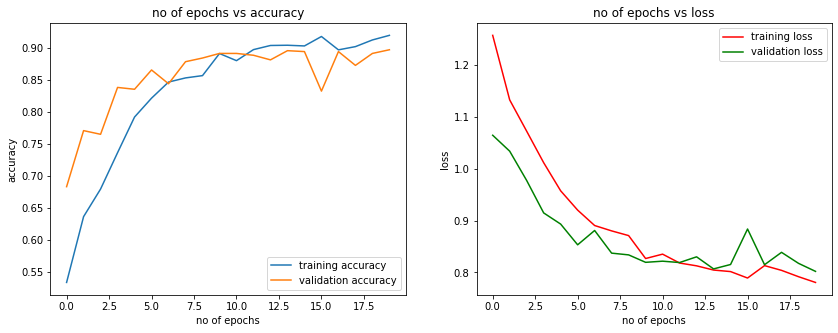

In [23]:
# Accuracy plot
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
acc=history2.history['acc']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)    
plt.plot(epochs_,acc,label='training accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

acc_val=history2.history['val_acc']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation accuracy")
plt.title("no of epochs vs accuracy")
plt.legend()

# loss plot
plt.subplot(1,2,2)
acc=history2.history['loss']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)    
plt.plot(epochs_,acc,label='training loss',color='r')
plt.xlabel('no of epochs')
plt.ylabel('loss')

acc_val=history2.history['val_loss']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation loss",color='g')
plt.title("no of epochs vs loss")
plt.legend()

In [24]:
Train_acc2=history2.history['acc'][-1]
Val_acc2=history2.history['val_acc'][-1]

model_acc["MobileNet"]=Train_acc2
model_val_acc["MobileNet"]=Val_acc2
print("Train accuracy",Train_acc2)
print("Validation accuracy",Val_acc2)

Train accuracy 0.9191810488700867
Validation accuracy 0.8967001438140869


In [25]:
predIdxs2 = model_2.predict(test_data, batch_size=32)
predIdxs2 = np.argmax(predIdxs2, axis=1)

22/22 [==============================] - 2s 44ms/step


In [26]:
# show a nicely formatted classification report
print(classification_report(test_labels.argmax(axis=1), predIdxs2))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       284
           1       0.97      1.00      0.98       209
           2       0.88      0.79      0.83       204

    accuracy                           0.90       697
   macro avg       0.90      0.90      0.90       697
weighted avg       0.90      0.90      0.90       697



[[256   5  23]
 [  1 208   0]
 [ 42   1 161]]


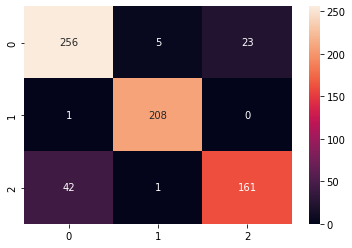

In [27]:
import seaborn as sns
cf2=confusion_matrix(test_labels.argmax(axis=1), predIdxs2)

sns.heatmap(cf2, annot=True,fmt="1.0f")
print(cf2)

# Inception v3

In [28]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import InceptionV3

In [29]:
model3 =InceptionV3(weights='imagenet',include_top=False ,input_shape=(224,224,3)
    )
model3.trainable = False
model3.summary()

87910968/87910968 [==============================] - 5s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)           

In [30]:
model_3 = Sequential([ 
        model3,   
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3,kernel_regularizer=l2(0.01), activation='softmax')
    ])
#Defining other parameters for our CNN model
model_3.compile(optimizer='adam',
              loss='squared_hinge',
              metrics=["acc"])

model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_8 (Dense)             (None, 256)               524544    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                        

In [31]:
EPOCHS = 20
history3 = model_3.fit(train_data, train_labels, validation_data=(test_data, test_labels),batch_size=32, epochs=EPOCHS)

Epoch 1/20
87/87 [==============================] - 15s 120ms/step - loss: 1.3365 - acc: 0.4846 - val_loss: 1.1221 - val_acc: 0.6557
Epoch 2/20
87/87 [==============================] - 8s 95ms/step - loss: 1.1748 - acc: 0.6049 - val_loss: 1.1140 - val_acc: 0.6600
Epoch 3/20
87/87 [==============================] - 8s 95ms/step - loss: 1.0910 - acc: 0.6739 - val_loss: 1.0230 - val_acc: 0.7288
Epoch 4/20
87/87 [==============================] - 8s 94ms/step - loss: 1.0387 - acc: 0.7195 - val_loss: 1.0320 - val_acc: 0.7288
Epoch 5/20
87/87 [==============================] - 9s 105ms/step - loss: 1.0065 - acc: 0.7493 - val_loss: 0.9603 - val_acc: 0.7762
Epoch 6/20
87/87 [==============================] - 8s 92ms/step - loss: 0.9674 - acc: 0.7830 - val_loss: 0.9462 - val_acc: 0.8006
Epoch 7/20
87/87 [==============================] - 9s 103ms/step - loss: 0.9580 - acc: 0.7848 - val_loss: 0.9242 - val_acc: 0.8164
Epoch 8/20
87/87 [==============================] - 8s 93ms/step - loss: 0.9393

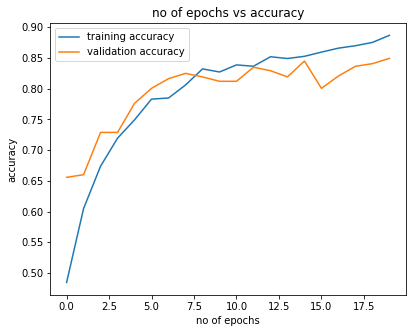

In [32]:
# Accuracy plot
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
acc=history3.history['acc'] 
 ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)    
plt.plot(epochs_,acc,label='training accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

acc_val=history3.history['val_acc']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation accuracy")
plt.title("no of epochs vs accuracy")
plt.legend()

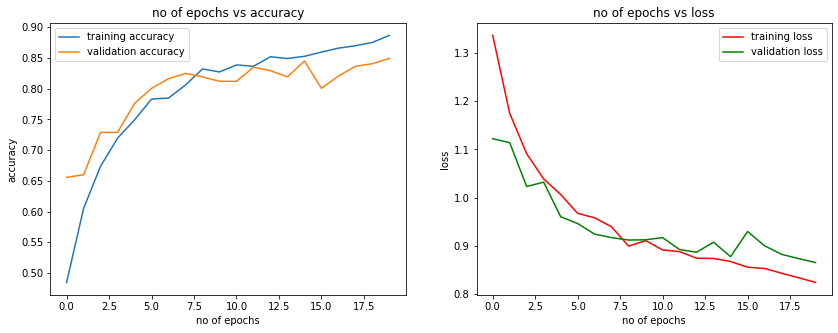

In [33]:
# Accuracy plot
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
acc=history3.history['acc']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)    
plt.plot(epochs_,acc,label='training accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

acc_val=history3.history['val_acc']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation accuracy")
plt.title("no of epochs vs accuracy")
plt.legend()

# loss plot
plt.subplot(1,2,2)
acc=history3.history['loss']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)    
plt.plot(epochs_,acc,label='training loss',color='r')
plt.xlabel('no of epochs')
plt.ylabel('loss')

acc_val=history3.history['val_loss']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation loss",color='g')
plt.title("no of epochs vs loss")
plt.legend()
plt.show()

In [34]:
Train_acc3=history3.history['acc'][-1]
Val_acc3=history3.history['val_acc'][-1]

model_acc["InceptionV3"]=Train_acc3
model_val_acc["InceptionV3"]=Val_acc3
print("Train accuracy",Train_acc3)
print("Validation accuracy",Val_acc3)

Train accuracy 0.8868534564971924
Validation accuracy 0.8493543863296509


In [35]:
predIdxs3 = model_3.predict(test_data, batch_size=32)
predIdxs3 = np.argmax(predIdxs3, axis=1)

22/22 [==============================] - 3s 73ms/step


In [36]:
print(classification_report(test_labels.argmax(axis=1), predIdxs3))

              precision    recall  f1-score   support

           0       0.81      0.86      0.84       284
           1       0.98      0.94      0.96       209
           2       0.77      0.75      0.76       204

    accuracy                           0.85       697
   macro avg       0.86      0.85      0.85       697
weighted avg       0.85      0.85      0.85       697



[[244   2  38]
 [  5 196   8]
 [ 51   1 152]]


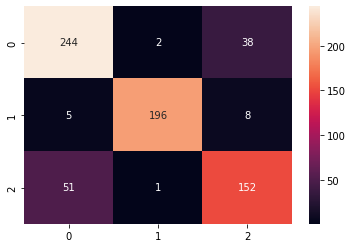

In [37]:
import seaborn as sns
cf3=confusion_matrix(test_labels.argmax(axis=1), predIdxs3)

sns.heatmap(cf3, annot=True,fmt="1.0f")
print(cf3)

# Model Evaluations

In [54]:
# training accuracy
model_scores = pd.DataFrame(model_acc, index=['Score']).transpose()
model_scores = model_scores.sort_values('Score',ascending=False)
model_scores

,Score
MobileNet,0.919181
InceptionV3,0.886853
SVC,0.867457
VGG16,0.862069


In [55]:
# test accuracy
model_scoress = pd.DataFrame(model_val_acc, index=['Score']).transpose()
model_scores_val = model_scoress.sort_values('Score',ascending=False)
model_scores_val

,Score
MobileNet,0.896700
VGG16,0.860832
InceptionV3,0.849354
SVC,0.786227


Text(0, 0.5, 'Test acc Score')

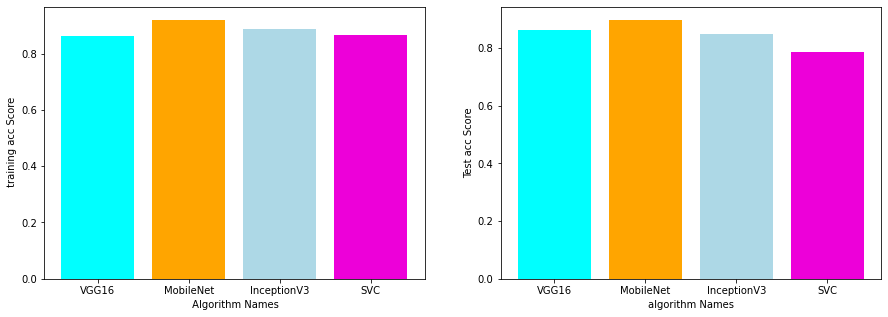

In [56]:
# training accuracy
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
namess = list(model_acc.keys())
valuess = list(model_acc.values())
colors=["#00FFFF","#FFA500","#ADD8E6","#ED00D9","#ED1400"]
textprops = {"fontsize":22}

#plt.figure(figsize=(6,3))
plt.bar(namess,valuess,color=colors)
plt.xlabel(" Algorithm Names")
plt.ylabel(" training acc Score")

# test accuracy
plt.subplot(1,2,2)
names = list(model_val_acc.keys())
values = list(model_val_acc.values())
colors=["#00FFFF","#FFA500","#ADD8E6","#ED00D9","#ED1400"]
textprops = {"fontsize":22}

#plt.figure(figsize=(6,3))
plt.bar(names,values,color=colors)
plt.xlabel("algorithm Names")
plt.ylabel("Test acc Score")